In [1]:
from functools import partial

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from crn_lyapunov.crn import ReactionNetwork, get_drift
from crn_lyapunov.smooth_lyapunov import SmoothLyapunov
from crn_lyapunov.training import Adversary, train_tight_sets
from crn_lyapunov.loss import MaxDrift, TightLoss, ProbabilityLoss, CombinedLoss
from crn_lyapunov.plot import (
    plot_drift_1d,
    plot_loss_traj,
    plot_level_set_comparison,
    plot_drift_2d,
)

In [2]:
def performance_table(
    model, net, ref_g, ranges, min_eps=-4, max_num_points=1000, device="cpu"
):
    ranges = [torch.arange(0, rng, max(1, rng // max_num_points)) for rng in ranges]

    meshes = torch.meshgrid(*ranges, indexing="xy")

    x_grid = torch.stack([mesh.flatten() for mesh in meshes], dim=1).to(device).float()

    with torch.no_grad():
        grid_drift = get_drift(model, net, x_grid).cpu().numpy()
        grid_drift_ref = get_drift(ref_g, net, x_grid).cpu().numpy()

    epsilons = np.logspace(min_eps, 0, 20)
    sizes_augs = list()
    sizes_refs = list()
    for eps in epsilons:
        size_aug = np.count_nonzero(grid_drift / grid_drift.max() * eps > eps - 1)
        size_ref = np.count_nonzero(
            grid_drift_ref / grid_drift_ref.max() * eps > eps - 1
        )
        sizes_augs.append(size_aug)
        sizes_refs.append(size_ref)

    return pd.DataFrame(
        {"epsilon": epsilons, "size_aug": sizes_augs, "size_ref": sizes_refs}
    )


def plot_performances(sizes: pd.DataFrame):
    fig, ax = plt.subplots()

    (l1,) = ax.plot(
        sizes["epsilon"], sizes["size_ref"], "ob:", label="reference size", lw=1
    )
    (l2,) = ax.plot(
        sizes["epsilon"], sizes["size_aug"], "or:", label="augmented size", lw=1
    )
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel("Set size")

    tax = ax.twinx()
    (l3,) = tax.plot(
        sizes["epsilon"],
        sizes["size_ref"] / sizes["size_aug"],
        "^k:",
        label=r"improvement",
        # lw=1,
    )

    tax.set_xscale("log")
    tax.set_ylabel("improvement")

    ax.legend(handles=[l1, l2, l3], loc="best")

# Birth-death

In [4]:
torch.manual_seed(0)
from crn_lyapunov.crn import BirthDeath

net = BirthDeath(200, 1)


def quadratic_ref(x):
    return x**2


model, adv, history, history_dmax = train_tight_sets(
    net,
    quadratic_ref,
    TightLoss(k=1),
    n_adv_samples=4,
    n_rand_samples=4,
    max_n=700,
    lr=1e-3,
    hidden_dim=128,
    steps_evolve=1,
    n_epochs=500,
)

  0%|          | 0/500 [00:00<?, ?it/s]

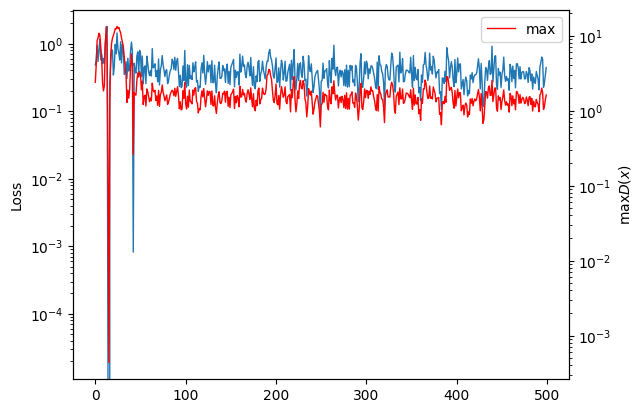

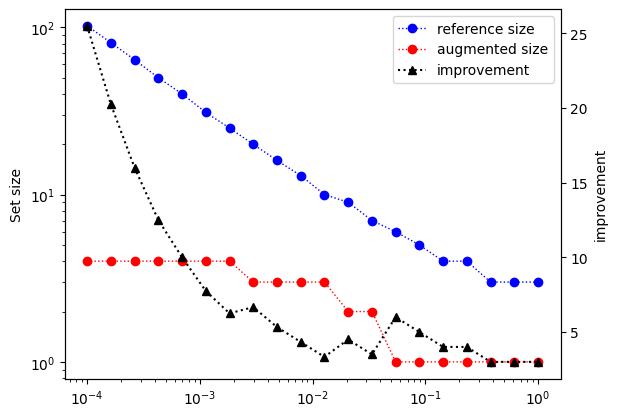

In [5]:
plot_loss_traj(history, history_dmax)
sizes = performance_table(model, net, quadratic_ref, [100_000])
plot_performances(sizes)

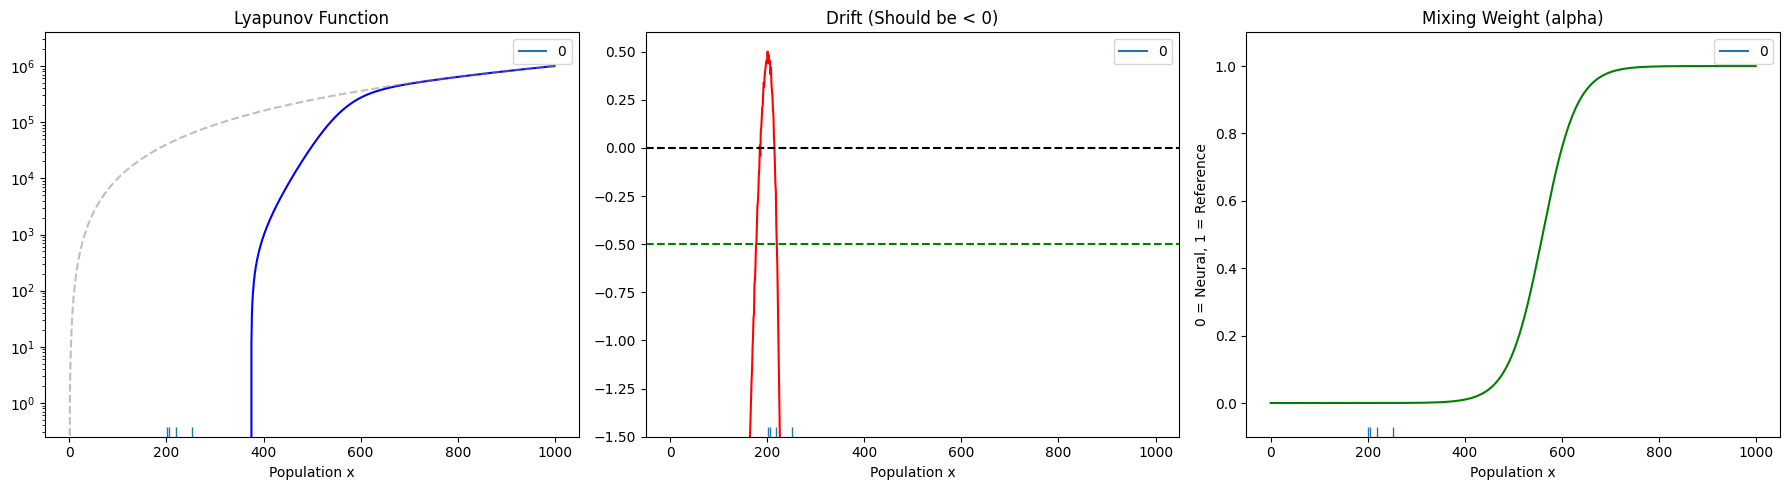

In [6]:
plot_drift_1d(1000, model, quadratic_ref, net, adv_population=adv.population)

In [30]:
# from scipy.stats import poisson
# import torch
# import numpy as np
# import matplotlib.pyplot as plt

# @torch.no_grad()
# def plot_level_set_comparison_with_optimum(model, network, reference_fn, mu, gamma, x_max=600, min_level=-4):
#     # 1. Setup State Space
#     x_range = torch.arange(start=0, end=x_max, step=max(1, x_max // 1000)).float().view(-1, 1)
#     x_np = x_range.numpy().flatten()

#     # 2. Compute Drifts & Ratios
#     # Augmented Model
#     drift_aug = get_drift(model, network, x_range).detach().numpy().flatten()
#     d_max_aug = np.max(drift_aug)
#     ratio_aug = drift_aug / d_max_aug

#     # Baseline Reference
#     class RefWrapper(torch.nn.Module):
#         def __init__(self, f):
#             super().__init__()
#             self.f = f
#         def forward(self, x):
#             return self.f(x)

#     drift_ref = get_drift(RefWrapper(reference_fn), network, x_range).detach().numpy().flatten()
#     d_max_ref = np.max(drift_ref)
#     ratio_ref = drift_ref / d_max_ref

#     # 3. Setup Mesh
#     eps_vals = np.logspace(min_level, 0, 300)
#     X, E = np.meshgrid(x_np, eps_vals)
#     thresholds = 1.0 - (1.0 / E)

#     # 4. Compute Sets
#     C_aug = ratio_aug[None, :] > thresholds
#     C_ref = ratio_ref[None, :] > thresholds

#     # 5. Compute Poisson Optimum (Ground Truth)
#     # The stationary distribution is Poisson(mu/gamma)
#     lam = mu / gamma
#     # For each eps, find the l_eps and h_eps such that mass is 1-eps
#     l_eps = poisson.ppf(eps_vals / 2, lam)
#     h_eps = poisson.ppf(1 - eps_vals / 2, lam)

#     # Create mask: True if x is within [l_eps, h_eps]
#     C_opt = (X >= l_eps[:, None]) & (X <= h_eps[:, None])

#     # 6. Plotting
#     fig, ax1 = plt.subplots(1, 1, figsize=(14, 6))

#     # Plot Reference (Blue) and Augmented (Red)
#     ax1.pcolormesh(X, E, C_ref, cmap="Blues", shading="auto", alpha=0.4, label="Linear Ref")
#     ax1.pcolormesh(X, E, C_aug, cmap="Reds", shading="auto", alpha=0.4, label="Augmented NN")

#     # Plot Optimum (Green Outline or subtle fill)
#     # We use a contour to show the boundary of the perfect set
#     ax1.contour(X, E, C_opt, levels=[0.5], colors='green', linestyles='dashed', linewidths=1.5)

#     # Styling
#     ax1.set_yscale("log")
#     ax1.set_ylabel(r"threshold $\epsilon$")
#     ax1.set_xlabel("State Space (x)")
#     ax1.set_title(f"Lyapunov Level Sets vs. Poisson Optimum ($\lambda={lam}$)")

#     # Custom Legend
#     from matplotlib.lines import Line2D
#     custom_lines = [Line2D([0], [0], color='blue', lw=4, alpha=0.4),
#                     Line2D([0], [0], color='red', lw=4, alpha=0.4),
#                     Line2D([0], [0], color='green', lw=2, linestyle='--')]
#     ax1.legend(custom_lines, ['Linear Reference Set', 'Augmented NN Set', r'Poisson Optimum (1-$\epsilon$ mass)'])

#     ax1.grid(True, which="both", ls="-", alpha=0.1)
#     plt.tight_layout()
#     plt.show()

# # Run with your parameters
# plot_level_set_comparison_with_optimum(
#     model, net, quadratic_ref,
#     mu=200.0, gamma=1.0,
#     min_level=-8, x_max=2000
# )

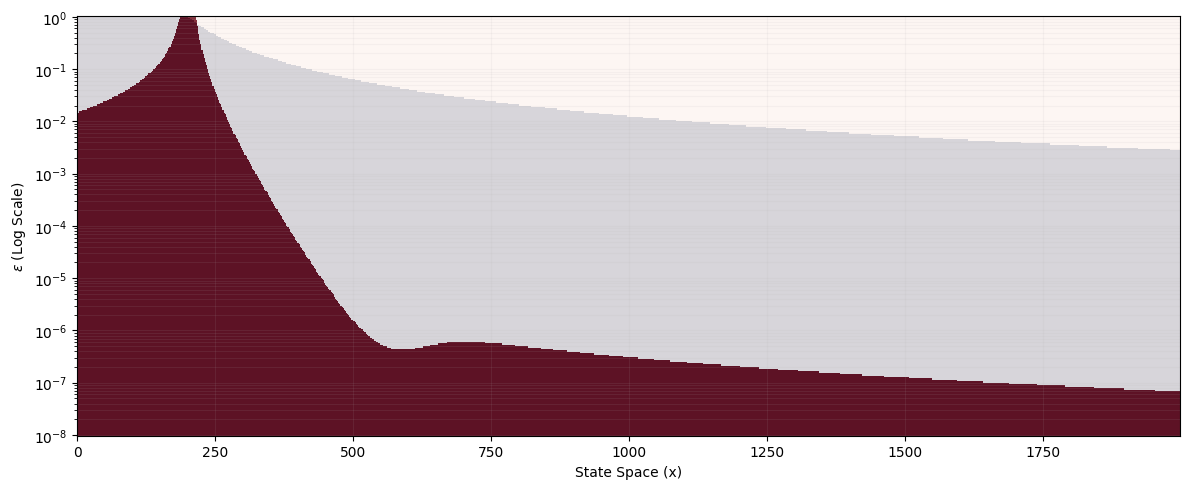

In [7]:
plot_level_set_comparison(model, net, quadratic_ref, min_level=-8, x_max=2000)

# Schloegl

In [8]:
def solve_schlogl_params(x_low, x_high, c2=0.001):
    x1 = x_low
    x3 = x_high
    x2 = (x1 + x3) / 2  # Midpoint for symmetry

    S = x1 + x2 + x3
    P = (x1 * x2) + (x2 * x3) + (x3 * x1)
    T = x1 * x2 * x3

    c1 = (c2 / 3) * S - c2
    c3 = (c2 / 6) * T
    c4 = (c2 / 6) * P - (c1 / 2) - (c2 / 3)

    return {"c1": c1, "c2": c2, "c3": c3, "c4": c4}


params = solve_schlogl_params(10, 100, c2=0.006)
print(params)

{'c1': 0.324, 'c2': 0.006, 'c3': 55.0, 'c4': 6.886}


Text(0.5, 1.0, 'Potential Wells (Minima = Modes)')

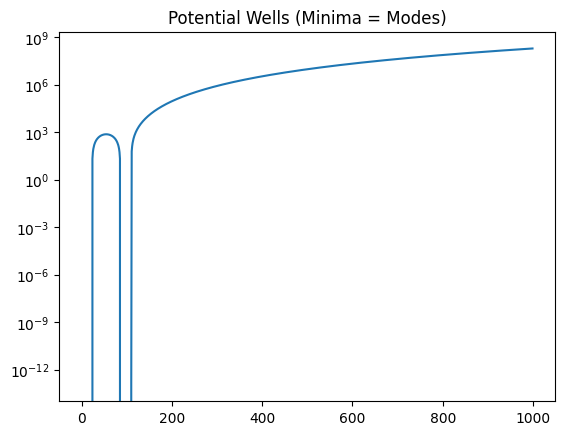

In [9]:
import numpy as np
import matplotlib.pyplot as plt


def get_potential(x_range, c1, c2, c3, c4):
    # Drift f(x)
    def f(x):
        return (c3 + 0.5 * c1 * x * (x - 1)) - (
            c4 * x + (c2 / 6) * x * (x - 1) * (x - 2)
        )

    # Potential is -integral of f(x)
    # We can approximate it by cumulative sum
    drift_vals = [f(x) for x in x_range]
    potential = -np.cumsum(drift_vals)
    return potential


x = np.arange(0, 1000)
tune = 15
pot = get_potential(x, **params)
plt.plot(x, pot)
plt.yscale("log")
plt.title("Potential Wells (Minima = Modes)")

In [10]:
from crn_lyapunov.crn import Schloegl

net = Schloegl(**params)

model, adv, history, history_dmax = train_tight_sets(
    net,
    quadratic_ref,
    TightLoss(),
    steps_evolve=5,
    n_adv_samples=8,
    n_rand_samples=8,
    max_n=500,
    lr=1e-3,
    hidden_dim=64,
    n_epochs=1000,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

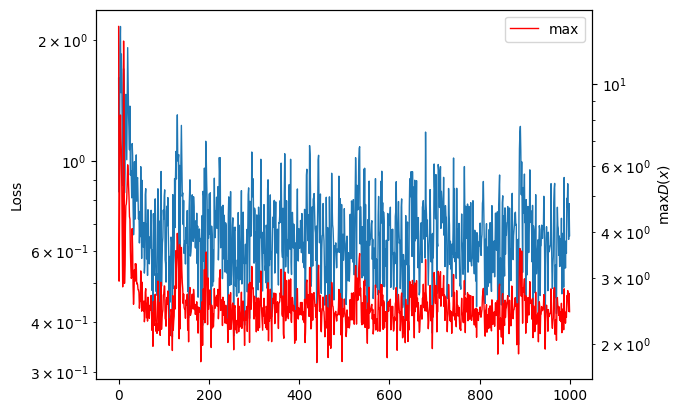

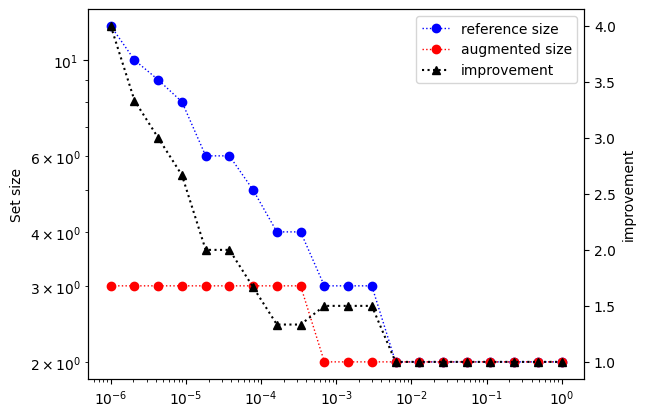

In [12]:
plot_loss_traj(history, history_dmax)
sizes = performance_table(model, net, quadratic_ref, [100_000], min_eps=-6)
plot_performances(sizes)

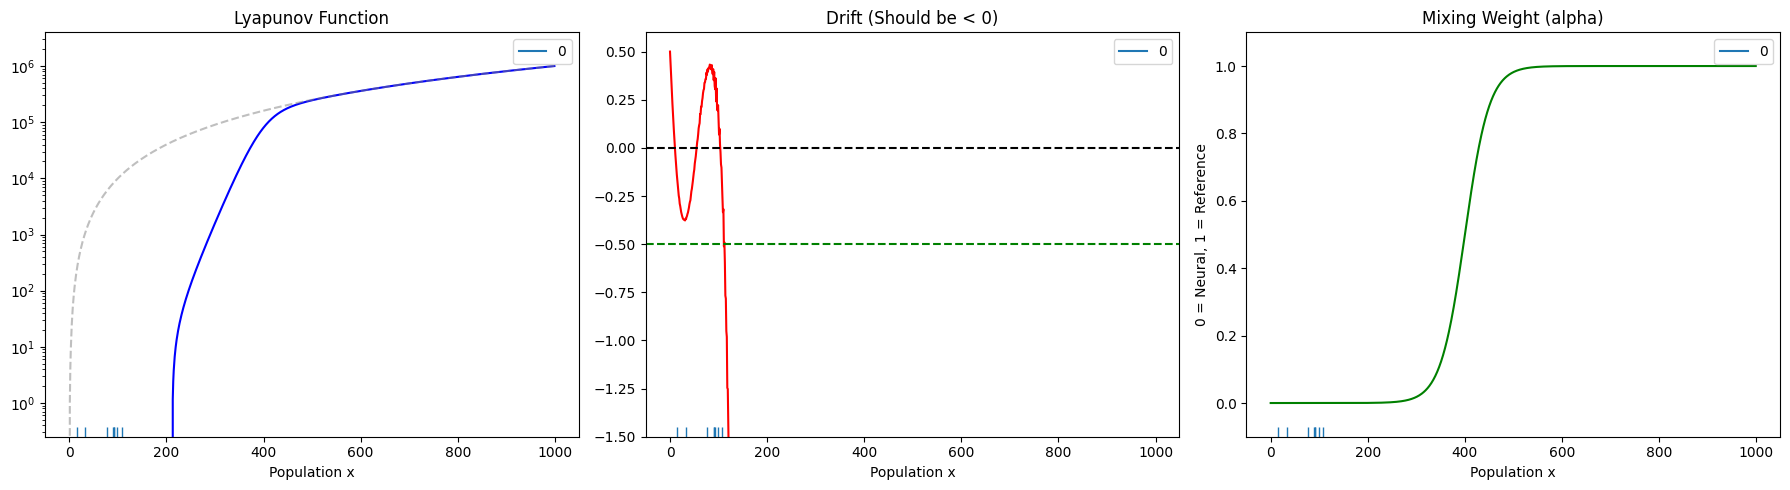

In [15]:
plot_drift_1d(1000, model, quadratic_ref, net, adv_population=adv.population)

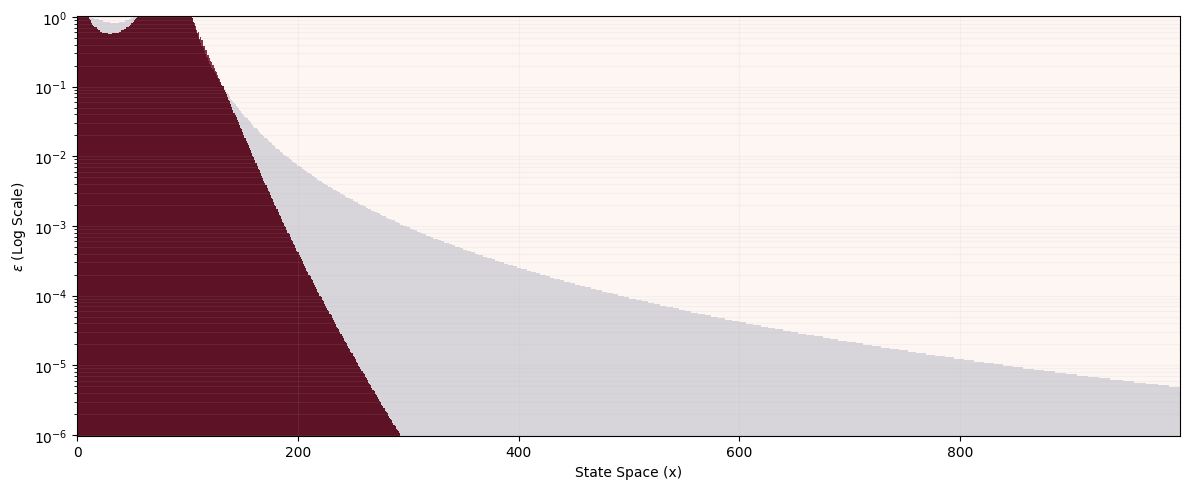

In [14]:
plot_level_set_comparison(model, net, quadratic_ref, x_max=1000, min_level=-6)

# Parallel birth-death

In [16]:
from crn_lyapunov.crn import ParBD


def ref_g(x):
    X, Y = x[:, 0:1], x[:, 1:2]
    return (X - 0) ** 2 + (Y - 0) ** 2


net_parbd = ParBD()

In [17]:
model_parbd, adv_parbd, h_loss, h_dmax = train_tight_sets(
    net_parbd,
    ref_g,
    TightLoss(k=0.1),
    steps_evolve=5,
    hidden_dim=128,
    n_adv_samples=2**8,
    n_rand_samples=2**8,
    max_n=300,
    n_epochs=10_000,
    lr=1e-3,
)

  0%|          | 0/10000 [00:00<?, ?it/s]

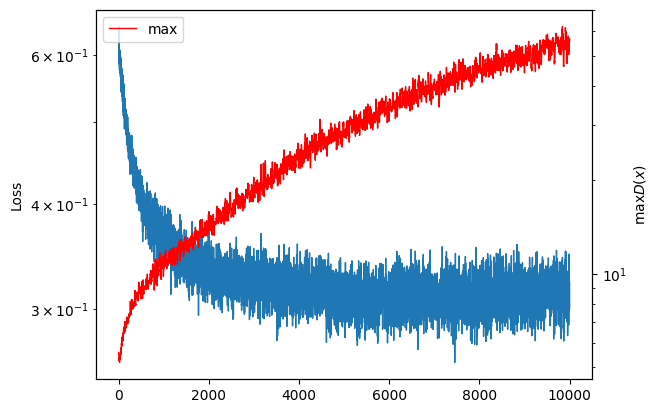

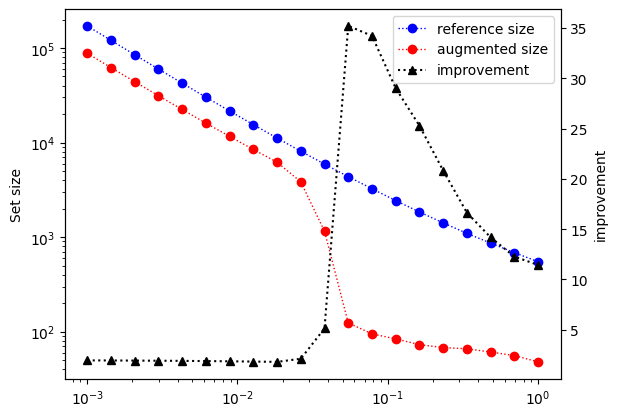

In [18]:
plot_loss_traj(h_loss, h_dmax)
sizes_p1 = performance_table(model_parbd, net_parbd, ref_g, [10_000, 10_000], min_eps=-3)
plot_performances(sizes_p1)

In [19]:
model_parbd, adv_parbd, h_loss, h_dmax = train_tight_sets(
    net_parbd,
    ref_g,
    TightLoss(k=1),
    steps_evolve=5,
    hidden_dim=128,
    n_adv_samples=2**8,
    n_rand_samples=2**8,
    max_n=300,
    n_epochs=10_000,
    lr=1e-3,
)

  0%|          | 0/10000 [00:00<?, ?it/s]

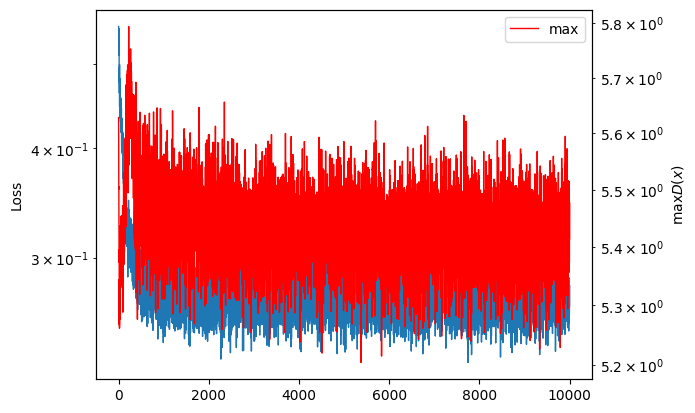

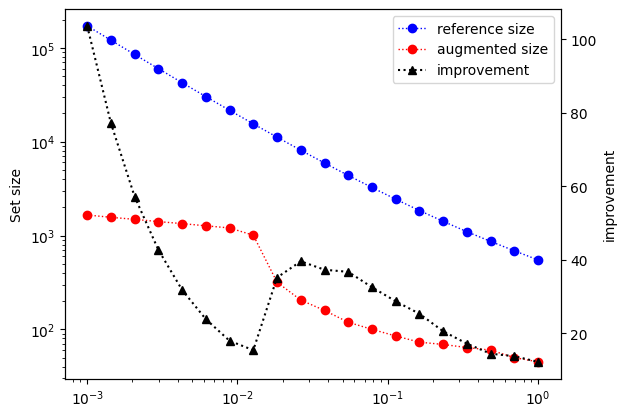

In [20]:
plot_loss_traj(h_loss, h_dmax)
sizes_1 = performance_table(model_parbd, net_parbd, ref_g, [10_000, 10_000], min_eps=-3)
plot_performances(sizes_1)

In [26]:
model_parbd, adv_parbd, h_loss, h_dmax = train_tight_sets(
    net_parbd,
    ref_g,
    TightLoss(k=10),
    steps_evolve=5,
    hidden_dim=128,
    n_adv_samples=2**8,
    n_rand_samples=2**8,
    max_n=300,
    n_epochs=10_000,
    lr=1e-3,
)

  0%|          | 0/10000 [00:00<?, ?it/s]

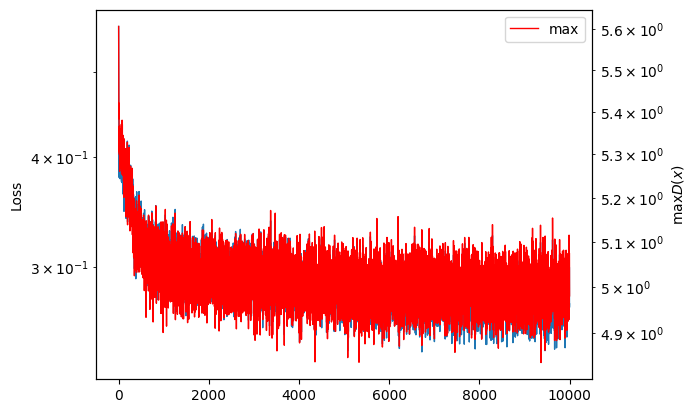

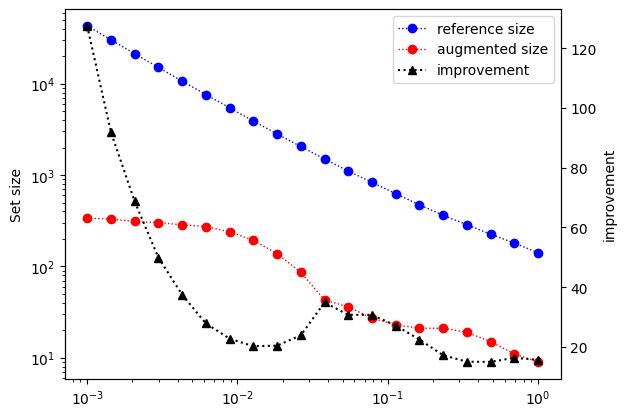

In [27]:
plot_loss_traj(h_loss, h_dmax)
sizes_10 = performance_table(model_parbd, net_parbd, ref_g, [10_000, 10_000], min_eps=-3)
plot_performances(sizes_10)

In [28]:
model_parbd, adv_parbd, h_loss, h_dmax = train_tight_sets(
    net_parbd,
    ref_g,
    TightLoss(k=100),
    steps_evolve=5,
    hidden_dim=128,
    n_adv_samples=2**8,
    n_rand_samples=2**8,
    max_n=300,
    n_epochs=10_000,
    lr=1e-3,
)

  0%|          | 0/10000 [00:00<?, ?it/s]

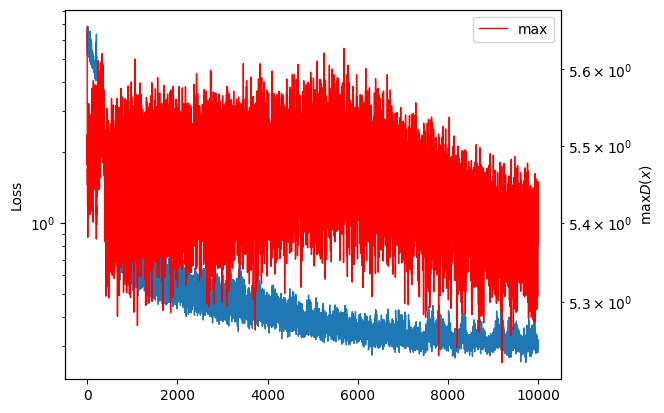

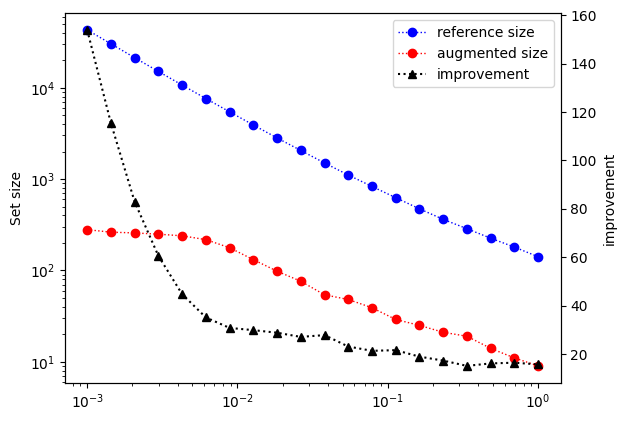

In [29]:
plot_loss_traj(h_loss, h_dmax)
sizes_100 = performance_table(model_parbd, net_parbd, ref_g, [10_000, 10_000], min_eps=-3)
plot_performances(sizes_100)

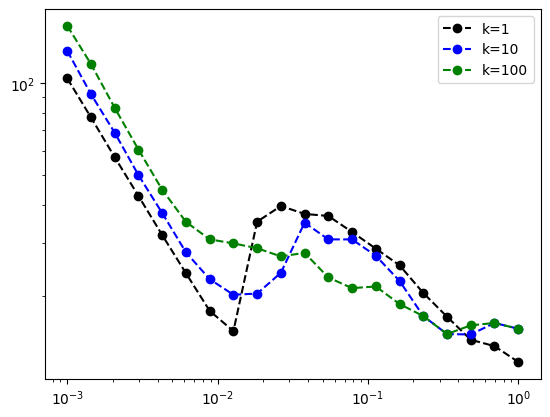

In [32]:
# plt.plot(
#     sizes_p1["epsilon"],
#     sizes_p1["size_ref"] / sizes_p1["size_aug"],
#     "or--",
#     label=r"k=0.1",
# )
plt.plot(
    sizes_1["epsilon"],
    sizes_1["size_ref"] / sizes_1["size_aug"],
    "ok--",
    label=r"k=1",
)
plt.plot(
    sizes_10["epsilon"],
    sizes_10["size_ref"] / sizes_10["size_aug"],
    "ob--",
    label=r"k=10",
)
plt.plot(
    sizes_100["epsilon"],
    sizes_100["size_ref"] / sizes_100["size_aug"],
    "og--",
    label=r"k=100",
)
plt.xscale("log")
plt.yscale("log")
plt.legend()

In [ ]:
plot_drift_2d(model_parbd, net_parbd, 300, 300, log_drift=True, adversary=adv_parbd)

# Toggle switch

In [47]:
from crn_lyapunov.crn import Toggle


def ref_g(x):
    X, Y = x[:, 0:1], x[:, 1:2]
    return (X - 0) ** 2 + (Y - 0) ** 2


net_toggle = Toggle(alpha=100, beta=0.1, k=10)

model_toggle, adv_toggle, h_loss, h_dmax = train_tight_sets(
    net_toggle,
    ref_g,
    TightLoss(k=1),
    steps_evolve=5,
    hidden_dim=1024,  # Smaller hidden_dim for fewer species
    n_adv_samples=2**8,
    n_rand_samples=2**8,
    max_n=3000,
    n_epochs=500,
    lr=1e-3,
)

  0%|          | 0/500 [00:00<?, ?it/s]

Training interrupted by user.


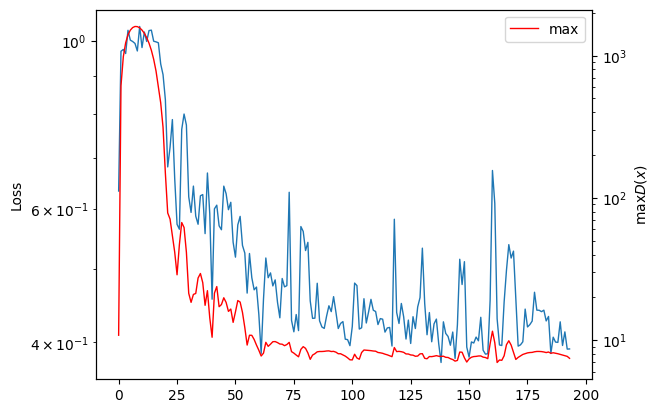

In [48]:
plot_loss_traj(h_loss, h_dmax)
# sizes = performance_table(model_toggle, net_toggle, ref_g, [10_000, 10_000], min_eps=-3)
# plot_performances(sizes)

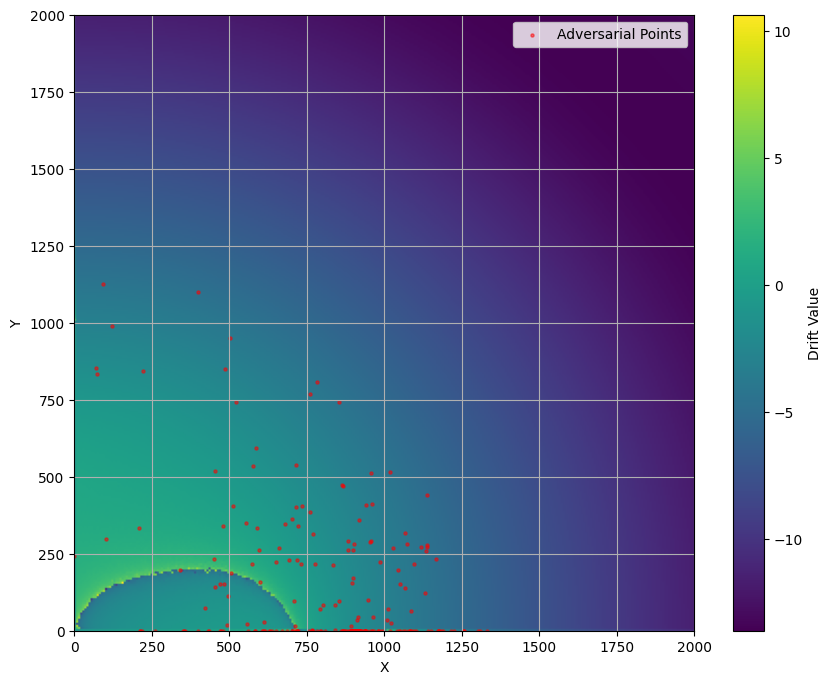

In [49]:
plot_drift_2d(model_toggle, net_toggle, 2000, 2000, log_drift=True, adversary=adv_toggle)

# Lotka-Volterra

In [84]:
# parameters
#   alpha = 1.0
#   beta = 0.001
#   gamma = 10.0
#   eps = 0.01

# species X Y

# reactions
#   X -> 2 X @ alpha * X;
#   X + Y -> 2 Y @ beta * X * Y;
#   Y -> 0 @ gamma * Y;
#   0 -> X @ eps;
#   X -> Y @ eps * X;


class LotkaVolterra(ReactionNetwork):
    def __init__(self):
        # Species Order: [Prey, Predator]
        S = torch.tensor(
            [
                [1.0, 0.0],  # Prey birth: X -> 2X
                [
                    -1.0,
                    1.0,
                ],  # Predation: X + Y -> 2Y (Prey decreases, Predator increases)
                [0.0, -1.0],  # Predator death: Y -> 0
                [1.0, 0.0],  # Prey materialization: 0 -> X
                [-1.0, 1.0],  # Prey conversion: X -> Y
                [-1.0, 0.0],  #
            ]
        )
        super().__init__(S, self._propensities)

        self.alpha = 1.0
        self.beta = 0.001
        self.gamma = 10.0
        self.eps = 0.01
        self.delta = 1e-4

    def _propensities(self, x):
        prey, predator = x[:, 0:1], x[:, 1:2]

        return torch.cat(
            [
                self.alpha * prey,  # Prey birth
                self.beta * prey * predator,  # Predation
                self.gamma * predator,  # Predator death
                torch.full_like(prey, self.eps),  # Prey materialization
                self.eps * prey,  # Prey-predator conversion
                self.delta * prey * (prey - 1),  # 2X -> X (The fix)
            ],
            dim=1,
        )


def centered_reference_g(x):
    x_star, y_star = 10000.0, 1000.0
    val = ((x[:, 0:1] - x_star) / x_star) ** 2 + ((x[:, 1:2] - y_star) / y_star) ** 2
    return val


net_lv = LotkaVolterra()

model_lv, adv_lv, h_loss_lv, h_dmax_lv = train_tight_sets(
    net_lv,
    ref_g,
    TightLoss(),
    steps_evolve=5,
    hidden_dim=512, 
    n_adv_samples=2**8,
    n_rand_samples=2**8,
    max_n=10_000,
    n_epochs=1000,
    lr=1e-3,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

Training interrupted by user.


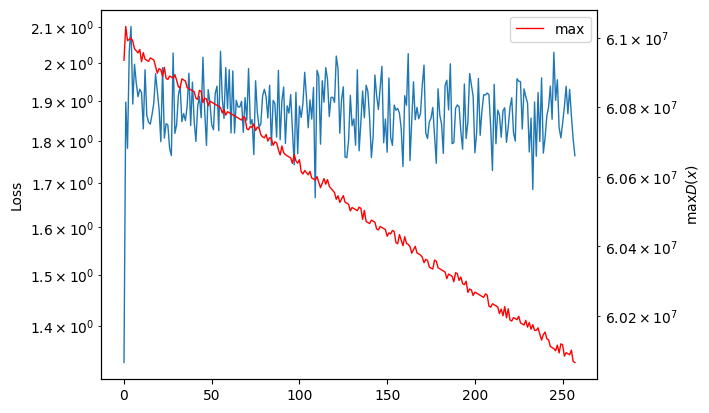

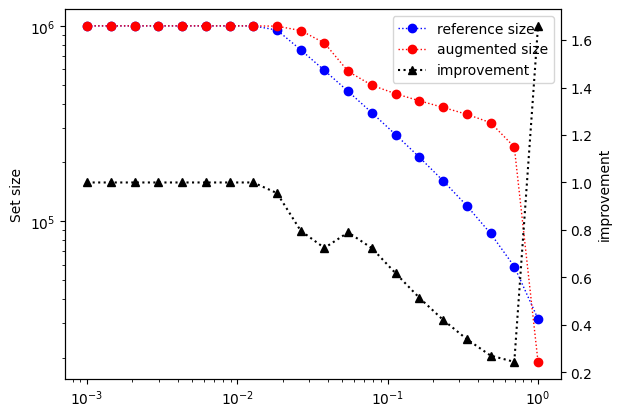

In [88]:
plot_loss_traj(h_loss_lv, h_dmax_lv)
plt.show()
sizes = performance_table(model_lv, net_lv, ref_g, [10_000, 10_000], min_eps=-3)
plot_performances(sizes)

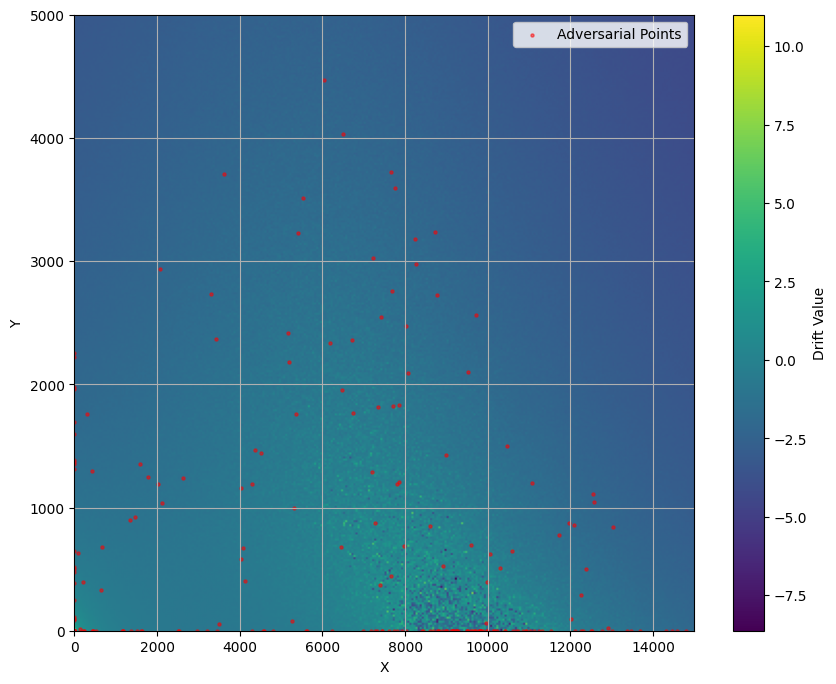

In [49]:
plot_drift_2d(model_lv, net_lv, 15000, 5000, log_drift=True, adversary=adv_lv)

# p53

In [3]:
from functools import partial

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from crn_lyapunov.crn import ReactionNetwork, get_drift
from crn_lyapunov.smooth_lyapunov import SmoothLyapunov
from crn_lyapunov.training import Adversary, train_tight_sets
from crn_lyapunov.loss import MaxDrift, TightLoss, ProbabilityLoss, CombinedLoss
from crn_lyapunov.plot import (
    plot_drift_1d,
    plot_loss_traj,
    plot_level_set_comparison,
    plot_drift_2d,
)

In [4]:
class P53Oscillator(ReactionNetwork):
    def __init__(self):
        # Species Order: [p53, pMdm2, Mdm2]
        # 0 -> p53           [1, 0, 0]
        # p53 -> 0           [-1, 0, 0]
        # p53 -> p53+pMdm2   [0, 1, 0]
        # p53 -> 0 (alpha4)  [-1, 0, 0]
        # pMdm2 -> Mdm2      [0, -1, 1]
        # Mdm2 -> 0          [0, 0, -1]
        S = torch.tensor(
            [
                [1.0, 0.0, 0.0],
                [-1.0, 0.0, 0.0],
                [0.0, 1.0, 0.0],
                [-1.0, 0.0, 0.0],
                [0.0, -1.0, 1.0],
                [0.0, 0.0, -1.0],
            ]
        )
        super().__init__(S, self._propensities)

        # Parameters
        self.k1, self.k2, self.k3 = 90.0, 0.002, 1.7
        self.k4, self.k5, self.k6 = 1.1, 0.93, 0.96
        self.k7 = 0.01

    def _propensities(self, x):
        p53, pMdm2, Mdm2 = x[:, 0:1], x[:, 1:2], x[:, 2:3]

        return torch.cat(
            [
                torch.full_like(p53, self.k1),  # k1
                self.k2 * p53,  # k2
                self.k4 * p53,  # k4
                self.k3 * Mdm2 * (p53 / (p53 + self.k7)),
                self.k5 * pMdm2,  # k5
                self.k6 * Mdm2,  # k6
            ],
            dim=1,
        )


def p53_reference_g(x):
    # g(x) = 120*p53 + 0.2*pMdm2 + 0.1*Mdm2
    weights = torch.tensor([120.0, 0.2, 0.1], device=x.device)
    return torch.sum(weights * x, dim=1, keepdim=True)

In [9]:
net_p53 = P53Oscillator()

model_p53, adv_p53, history_loss, history_max = train_tight_sets(
    net_p53,
    p53_reference_g,
    TightLoss(k=1),
    # CombinedLoss(dmax_weight=0.1, gamma=0.0),
    # MaxDrift(),
    steps_evolve=15,
    hidden_dim=512,
    n_adv_samples=2**13,
    n_rand_samples=2**13,
    max_n=3000,
    n_epochs=1000,
    lr=1e-3,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

Training interrupted by user.


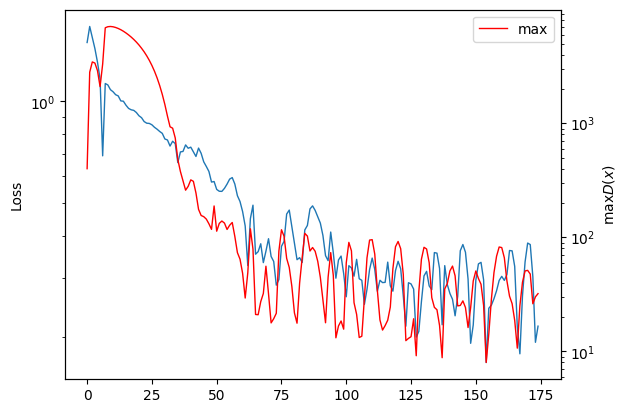

In [10]:
plot_loss_traj(history_loss, history_max)

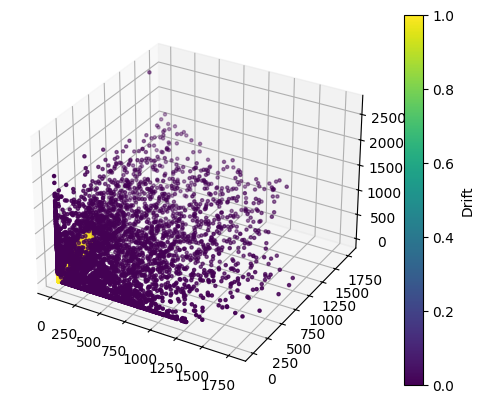

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

with torch.no_grad():
    drift = get_drift(model_p53, net_p53, adv_p53.population).numpy()

points = adv_p53.population.detach().numpy()

# Plot the point cloud and keep the mappable
sc = ax.scatter(
    points[:, 0], points[:, 1], points[:, 2], c=drift.flatten()>0, cmap="viridis", s=5
)
dmax = drift.max()

# Add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Drift")

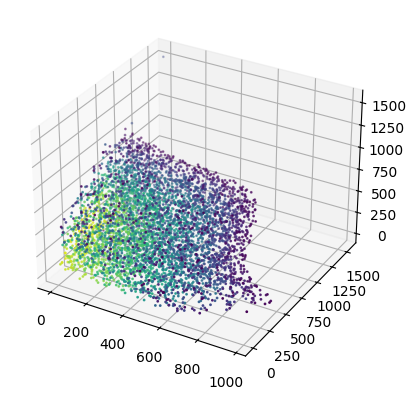

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

n = 100000
points = eval_xs = torch.rand(n, 3) * torch.tensor([2000, 2000, 2000])
with torch.no_grad():
    drift = get_drift(model_p53, net_p53, points).numpy()

eps = 1e-1
in_set = drift.flatten() / dmax * eps > eps - 1

drift = drift[in_set]
points = points[in_set]

# Plot the point cloud and keep the mappable
sc = ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=drift, cmap="viridis", s=1)

plt.show()

In [13]:
import pyvista as pv
import torch
import numpy as np

pv.set_jupyter_backend("trame")  # or "static"
plotter = pv.Plotter(notebook=True)
# Generate points
n = 100000
points = torch.rand(n, 3) * torch.tensor([1500, 1500, 1500])

with torch.no_grad():
    drift = get_drift(model_p53, net_p53, points)

# Move to NumPy
points_np = points.cpu().numpy()
drift_np = drift.cpu().numpy().flatten()

# Same mask as before
eps = 0.1
in_set = drift_np / dmax * eps > eps - 1

points_np = points_np[in_set]
drift_np = drift_np[in_set]

# Create PyVista point cloud
cloud = pv.PolyData(points_np)
cloud["drift"] = drift_np  # attach scalar data

# Plot
plotter = pv.Plotter()
plotter.add_points(
    cloud,
    scalars="drift",
    cmap="viridis",
    point_size=5,
    render_points_as_spheres=True,
)
plotter.add_axes()
plotter.show()

Widget(value='<iframe src="http://localhost:45193/index.html?ui=P_0x7f0ccc70fd90_10&reconnect=auto" class="pyv…

In [ ]:
import pandas as pd

In [ ]:
n = 1_000_000
eval_xs = torch.rand(n, 3) * 10_000
with torch.no_grad():
    d_ref = get_drift(p53_reference_g, net_p53, eval_xs).numpy()
    d_aug = get_drift(model_p53, net_p53, eval_xs).numpy()

c_ref = np.max(d_ref)  # 10800.0
c_aug = max(np.max(d_aug), 35)

eps_list = [0.9, 0.1, 0.01, 0.001]
rows = []
for eps in eps_list:
    thresh = 1 - (1 / eps)
    count_ref = np.sum(d_ref / c_ref > thresh)
    count_aug = np.sum(d_aug / c_aug > thresh)
    rows.append(
        {
            "epsilon": eps,
            "ref_in_set": int(count_ref) / n,
            "aug_in_set": int(count_aug) / n,
        }
    )
print(c_ref, c_aug)
df_final = pd.DataFrame(rows)
df_final

In [ ]:
for _ in tqdm.tqdm(range(100_000)):
    for _ in range(100_000):
        #     for _ in range(100_000):
        pass